In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)
# reflect the tables

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
# Assign the station class to a variable called `Station`
Station = Base.classes.station
# Assign the measurement class to a variable called `Measurement`
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
# Create a session
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
temps = calc_temps('2017-08-01', '2018-08-01')[0]

tmin = temps[0]
tavg = temps[1]
tmax = temps[2]

tmin, tavg, tmax

(70.0, 78.82417582417582, 85.0)

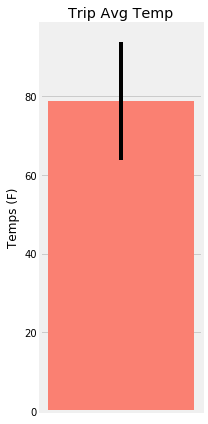

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3, 6))
plt.bar(x=1, height=tavg, yerr=(tmax-tmin), color='salmon')
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel("Temps (F)")
plt.tight_layout()
plt.savefig('bonus_temperature.png')
# temps_df = pd.DataFrame({"tmin": [tmin],
#                         "tavg": [tavg],
#                         "tmax": [tmax]})
# temps_df['tavg'].plot.bar(yerr=(tmax - tmin), figsize=(4, 10), title='Trip Avg Temp')

### Daily Rainfall Average

In [35]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_stations = session.query(Station.station, Station.name, Station.latitude,
                                 Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
        filter(Measurement.date >= dt.date(2017,8,1), Measurement.date <= dt.date(2018,8,1)).\
        filter(Measurement.prcp != None).\
        filter(Station.station == Measurement.station).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()
rain_stations
rain_df = pd.DataFrame(rain_stations, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'Rainfall'])
rain_df

,Station,Name,Latitude,Longitude,Elevation,Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.85
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.57
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.36
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.34
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.06


In [36]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [108]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
arr_dates = np.arange(dt.datetime(2017,8,1), dt.datetime(2017,8,7), dt.timedelta(days=1)).astype(dt.datetime)


# Strip off the year and save a list of strings in the format %m-%d
dates = []
for d in arr_dates:
    d = str(d)
    date = d.split(' ')[0].split('2017-')[1]
    dates.append(date)
dates

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for d in dates:
    date = daily_normals(d)[0]
    normals.append(date)
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0)]

In [129]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
normals_df['date'] = arr_dates
normals_df['date'] = normals_df['date'].astype(str)
normals_df = normals_df.set_index('date', drop=True)

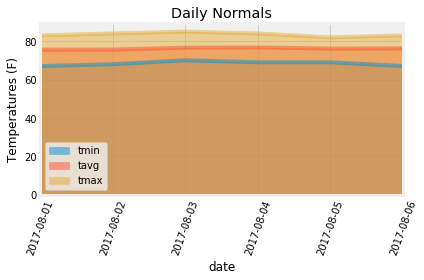

In [131]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df
normals_df.plot(kind='area', stacked=False, title='Daily Normals', rot=70)
plt.ylabel("Temperatures (F)")
plt.savefir
plt.show()

## Close Session

In [ ]:
session.close()